In [237]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

pd.options.display.float_format = '{:.1f}'.format


## Download the NFL Data

In [288]:
REMOTE_PATH_TEMPLATE = 'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_{year}.csv.gz?raw=True'

def download_play_by_play(year: int) -> pd.DataFrame:
    """Download CSV from remote path."""
    path = REMOTE_PATH_TEMPLATE.format(year=year)
    return pd.read_csv(
        path,
        compression='gzip' if "csv.gz" in path else "infer",
        low_memory=False
    )

years = range(2010, 2021)

df_raw = download_play_by_play(2021)
for year in years:
    df_new = download_play_by_play(year)
    df_raw = pd.concat([df_raw, df_new])

In [289]:
# df_raw = download_play_by_play(2021)
df_raw.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,NaN,NaN,NaN,...,0,1,nan,nan,nan,nan,nan,nan,nan,nan
1,40,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0,1,0.0,nan,nan,nan,nan,nan,nan,nan
2,55,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0,1,-1.4,nan,nan,nan,nan,nan,0.5,-49.1
3,76,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0,1,0.0,1.2,5.8,4.0,0.9,0.1,0.7,30.3
4,100,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0,1,-1.5,0.3,4.1,2.0,1.0,1.0,1.0,2.2


In [290]:
df_raw.shape

(556083, 372)

## EDA

In [291]:
cols = sorted(df_raw.columns)
print(cols)

['aborted_play', 'air_epa', 'air_wpa', 'air_yards', 'assist_tackle', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 'assist_tackle_4_team', 'away_coach', 'away_score', 'away_team', 'away_timeouts_remaining', 'away_wp', 'away_wp_post', 'blocked_player_id', 'blocked_player_name', 'comp_air_epa', 'comp_air_wpa', 'comp_yac_epa', 'comp_yac_wpa', 'complete_pass', 'cp', 'cpoe', 'def_wp', 'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'defensive_two_point_attempt', 'defensive_two_point_conv', 'defteam', 'defteam_score', 'defteam_score_post', 'defteam_timeouts_remaining', 'desc', 'div_game', 'down', 'drive', 'drive_end_transition', 'drive_end_yard_line', 'drive_ended_with_score', 'drive_first_downs', 'drive_game_clock_

In [292]:
"""
WHERE
    play_type = 'pass' AND sack = 0 AND two_point_attempt = 0
GROUP BY
    year, week, passer_id, passer_position,
    p.game_id, defteam, posteam, passer, season_type
"""
filters = (df_raw['play_type'] == 'pass') & \
    (df_raw['sack'] == 0) & \
    (df_raw['two_point_attempt'] == 0) & \
    (df_raw['pass_attempt'] == 1) & \
    (df_raw['season_type'] == 'REG')
    

grouping_columns = [
    'season',
    'posteam',
    'passer_player_name'
]

sum_columms = [
    'complete_pass',
    'pass_attempt',
    'pass_touchdown',
    'interception',
    'yards_gained',
    'air_yards',
    'yards_after_catch',
    'xyac_median_yardage',
    'xyac_mean_yardage',
]

subset_columns = grouping_columns + sum_columms

In [293]:
df_filtered = df_raw[filters]
df_filtered.shape

(204945, 372)

In [294]:
df = df_filtered[subset_columns].groupby(grouping_columns).sum().reset_index()
df.shape

(1158, 12)

In [295]:
rename_columns = {
    "passer_player_name": "player",
    'complete_pass': 'completions',
    'pass_attempt': 'attempts',
    'pass_touchdown': 'td',
    'interception': 'int',
    'yards_gained': 'yards',
    'air_yards': 'ay',
    'xyac_median_yardage': 'xyac_median',
    'xyac_mean_yardage': 'xyac_mean',
    'yards_after_catch': 'yac',
}

df = df.rename(columns=rename_columns)
df = df[df['attempts'] > 100]

In [296]:
def print_df(df, k='y/a', asc=False, n=20):
    display(df.sort_values(k, ascending=asc).head(n))


def transform(df):
    df['y/a'] = df['yards'] / df['attempts']
    df['ay/a'] = df['ay'] / df['attempts']
    df['comp_ay'] = df['yards'] - df['yac']
    df['yip_mean'] = df['comp_ay'] + df['xyac_mean']
    df['yip_median'] = df['comp_ay'] + df['xyac_median']
    df['yip/a'] = df['yip_median'] / df['attempts']
    df['yip/a_diff'] = df['yip/a'] - df['y/a']
    df['y/a_rank'] = (df['y/a'].rank(ascending=False)).astype(int)
    df['yip/a_rank'] = (df['yip/a'].rank(ascending=False)).astype(int)
    df['rank_diff'] = (df['y/a_rank'] - df['yip/a_rank']).astype(int)

    return df

In [297]:
df = transform(df)
print_df(df)

,season,posteam,player,completions,attempts,td,int,yards,ay,yac,...,y/a,ay/a,comp_ay,yip_mean,yip_median,yip/a,yip/a_diff,y/a_rank,yip/a_rank,rank_diff
955,2019,TEN,R.Tannehill,201.0,283.0,22.0,6.0,2742.0,2739.0,1224.0,...,9.7,9.7,1518.0,2803.6,2350.0,8.3,-1.4,1,6,-5
845,2018,TB,R.Fitzpatrick,164.0,246.0,17.0,12.0,2366.0,2546.0,874.0,...,9.6,10.3,1492.0,2618.0,2214.0,9.0,-0.6,2,1,1
1146,2021,SEA,R.Wilson,90.0,125.0,10.0,1.0,1196.0,1139.0,575.0,...,9.6,9.1,621.0,1269.3,1052.0,8.4,-1.2,3,3,0
137,2011,GB,A.Rodgers,343.0,500.0,45.0,6.0,4643.0,4554.0,2017.0,...,9.3,9.1,2626.0,4884.6,4092.0,8.2,-1.1,4,9,-5
564,2016,ATL,M.Ryan,373.0,534.0,38.0,7.0,4944.0,4619.0,2262.0,...,9.3,8.6,2682.0,5149.7,4270.0,8.0,-1.3,5,18,-13
355,2013,PHI,N.Foles,203.0,317.0,27.0,2.0,2891.0,2962.0,1385.0,...,9.1,9.3,1506.0,3076.6,2593.0,8.2,-0.9,6,10,-4
1008,2020,HOU,D.Watson,382.0,542.0,33.0,7.0,4823.0,4837.0,1954.0,...,8.9,8.9,2869.0,5276.4,4404.0,8.1,-0.8,7,12,-5
1077,2021,ARI,K.Murray,186.0,256.0,17.0,7.0,2276.0,2089.0,1040.0,...,8.9,8.2,1236.0,2522.9,2144.0,8.4,-0.5,8,5,3
743,2017,SF,J.Garoppolo,120.0,176.0,7.0,5.0,1560.0,1572.0,721.0,...,8.9,8.9,839.0,1557.0,1275.0,7.2,-1.6,9,196,-187
806,2018,KC,P.Mahomes,383.0,579.0,50.0,12.0,5097.0,5255.0,2613.0,...,8.8,9.1,2484.0,5315.0,4446.0,7.7,-1.1,10,59,-49


## Visualizations

<AxesSubplot:xlabel='yards_after_catch', ylabel='xyac_median_yardage'>

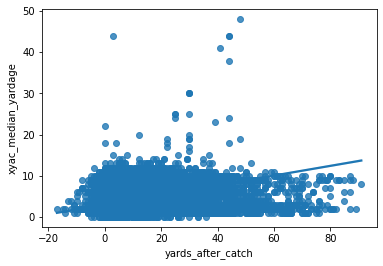

In [298]:
sns.regplot(data=df_filtered, x='yards_after_catch', y='xyac_median_yardage')

<AxesSubplot:xlabel='yards_after_catch', ylabel='xyac_mean_yardage'>

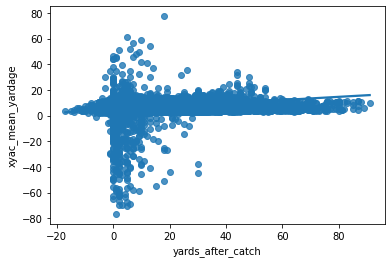

In [299]:
sns.regplot(data=df_filtered, x='yards_after_catch', y='xyac_mean_yardage')

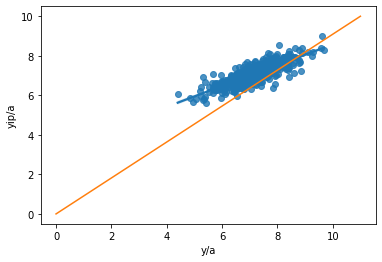

In [300]:
sns.regplot(data=df, x='y/a', y='yip/a')
plt.plot(np.linspace(0, 10, 12))

<AxesSubplot:xlabel='yip/a_diff', ylabel='Count'>

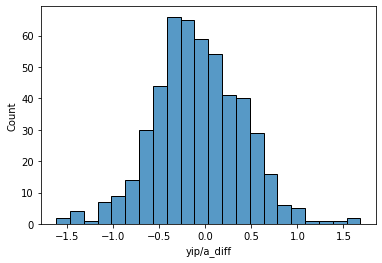

In [301]:
sns.histplot(data=df['yip/a_diff'])

## Results

In [302]:
cols = [
    'season', 'posteam', 'player', 'y/a_rank', 'yip/a_rank', 'rank_diff',
    'y/a', 'yip/a', 'yip/a_diff', 
]
print_df(df[cols], 'y/a_rank', asc=True, n=15)

,season,posteam,player,y/a_rank,yip/a_rank,rank_diff,y/a,yip/a,yip/a_diff
955,2019,TEN,R.Tannehill,1,6,-5,9.7,8.3,-1.4
845,2018,TB,R.Fitzpatrick,2,1,1,9.6,9.0,-0.6
1146,2021,SEA,R.Wilson,3,3,0,9.6,8.4,-1.2
137,2011,GB,A.Rodgers,4,9,-5,9.3,8.2,-1.1
564,2016,ATL,M.Ryan,5,18,-13,9.3,8.0,-1.3
355,2013,PHI,N.Foles,6,10,-4,9.1,8.2,-0.9
1008,2020,HOU,D.Watson,7,12,-5,8.9,8.1,-0.8
1077,2021,ARI,K.Murray,8,5,3,8.9,8.4,-0.5
743,2017,SF,J.Garoppolo,9,196,-187,8.9,7.2,-1.6
806,2018,KC,P.Mahomes,10,59,-49,8.8,7.7,-1.1


In [303]:
print_df(df[cols], 'yip/a_rank', asc=True)

,season,posteam,player,y/a_rank,yip/a_rank,rank_diff,y/a,yip/a,yip/a_diff
845,2018,TB,R.Fitzpatrick,2,1,1,9.6,9.0,-0.6
100,2010,TEN,V.Young,65,2,63,8.0,8.6,0.5
1146,2021,SEA,R.Wilson,3,3,0,9.6,8.4,-1.2
893,2019,DET,M.Stafford,15,4,11,8.6,8.4,-0.2
1077,2021,ARI,K.Murray,8,5,3,8.9,8.4,-0.5
955,2019,TEN,R.Tannehill,1,6,-5,9.7,8.3,-1.4
472,2015,ARI,C.Palmer,11,7,4,8.8,8.3,-0.5
546,2015,PIT,B.Roethlisberger,27,8,19,8.4,8.3,-0.1
137,2011,GB,A.Rodgers,4,9,-5,9.3,8.2,-1.1
355,2013,PHI,N.Foles,6,10,-4,9.1,8.2,-0.9


In [304]:
print_df(df[cols], 'yip/a_diff', asc=True)

,season,posteam,player,y/a_rank,yip/a_rank,rank_diff,y/a,yip/a,yip/a_diff
743,2017,SF,J.Garoppolo,9,196,-187,8.9,7.2,-1.6
842,2018,SF,N.Mullens,24,293,-269,8.4,6.9,-1.5
1062,2020,SF,J.Garoppolo,101,462,-361,7.8,6.4,-1.5
170,2011,NE,T.Brady,18,213,-195,8.6,7.2,-1.4
955,2019,TEN,R.Tannehill,1,6,-5,9.7,8.3,-1.4
471,2014,WAS,R.Griffin,90,420,-330,7.9,6.6,-1.3
564,2016,ATL,M.Ryan,5,18,-13,9.3,8.0,-1.3
1146,2021,SEA,R.Wilson,3,3,0,9.6,8.4,-1.2
310,2013,GB,A.Rodgers,13,69,-56,8.8,7.6,-1.1
806,2018,KC,P.Mahomes,10,59,-49,8.8,7.7,-1.1


In [305]:
print_df(df[cols], 'yip/a_diff', asc=False)

,season,posteam,player,y/a_rank,yip/a_rank,rank_diff,y/a,yip/a,yip/a_diff
204,2012,ARI,R.Lindley,497,486,11,4.4,6.1,1.7
1,2010,ARI,J.Skelton,490,308,182,5.3,6.9,1.6
891,2019,DET,D.Blough,481,239,242,5.7,7.1,1.4
126,2011,CLE,S.Wallace,486,383,103,5.4,6.7,1.3
509,2015,HOU,R.Mallett,491,449,42,5.2,6.4,1.2
981,2020,CHI,N.Foles,466,260,206,6.0,7.0,1.1
918,2019,MIA,J.Rosen,493,480,13,5.2,6.2,1.0
657,2017,ARI,D.Stanton,482,411,71,5.6,6.6,1.0
729,2017,NYJ,B.Petty,496,492,4,4.9,5.8,1.0
1139,2021,NYJ,Z.Wilson,413,144,269,6.5,7.4,0.9
